In [1]:
from flash_ansr import FlashANSR, SoftmaxSamplingConfig, install_model, get_path, ConvergenceError
from flash_ansr.expressions.compilation import codify
from flash_ansr.expressions.token_ops import identify_constants, flatten_nested_list

import torch
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'ansr-models/v23.0-120M'

In [3]:
model = FlashANSR.load(
    directory=get_path('models', MODEL),
    generation_config=SoftmaxSamplingConfig(choices=1024 * 32),
    parsimony=0.05,
).to(device)

# 1D

In [ ]:
positive_demo_expressions = [
    ('(x - 0.3)**2', (0.3,), (-5, 5)),
    ('1 * sin(1 * x + 1)', (0.85, 1.1, 0.2), (-5, 5)),
    ('x**2 + 2*x + 1', (2, 1), (1, 5)),
    ('exp(- x**2)', None, (-5, 5)),
    ('x**3 + 2*x**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x - 3.4)**2)', (3.4,), (-5, 5)),
    ('exp(- (x - 1.4)**2 / 4.3)', (1.4, 4.3), (-5, 5)),
    ('cos(3.3 * x) * exp(-x * 0.5)', (3.3, 0.5,), (0, 5)),
    ('1.2', (1.2,), (-5, 5)),
    ('sin(tan(x))', None, (-5, 5)),
    ('asin((sin(x) / x))', None, (-10, 10)),
    ('-x + log(x + x**4)', None, (1, 5)),
]

positive_results = []

for results, demo_expressions in zip([positive_results], [positive_demo_expressions]):
    for expression, constants, xlim in tqdm(demo_expressions):
        parsed_expression = model.simplipy_engine.parse(expression, mask_numbers=True)
        executable_prefix_expression = model.simplipy_engine.operators_to_realizations(parsed_expression)
        prefix_expression_with_constants, constants_names = identify_constants(executable_prefix_expression, inplace=True)
        code_string = model.simplipy_engine.prefix_to_infix(prefix_expression_with_constants, realization=True)
        code = codify(code_string, ['x'] + constants_names)

        if constants is None:
            demo_function = lambda x: model.simplipy_engine.code_to_lambda(code)(x)
        else:
            demo_function = lambda x: model.simplipy_engine.code_to_lambda(code)(x, *constants)

        x = np.random.uniform(*xlim, 64)
        x = x.reshape(-1, 1)

        y = demo_function(x)
        if isinstance(y, float):
            y = np.full_like(x, y)
        # y = y + np.std(y).clip(0.05, None) * 0.03 * np.random.randn(*y.shape)

        x_linspace = np.linspace(xlim[0] - 0.5, xlim[1] + 0.5, 1000).reshape(-1, 1)
        y_linspace = demo_function(x_linspace)

        model.fit(x, y, verbose=True)

        results.append({
            'x': x,
            'y': y,
            'y_pred': model.predict(x),
            'x_linspace': x_linspace,
            'y_linspace': y_linspace,
            'y_linspace_pred': model.predict(x_linspace),
            'expression': expression,
            'expression_pred': model.get_expression(),
            'constants': constants,
            'fvu': np.var(y - model.predict(x)) / np.var(y) if np.var(y) > 0 else 0.0,
            'log_p': model.results['log_prob'][0]
        })

Fitting Constants: 100%|██████████| 31571/31571 [00:18<00:00, 1735.04it/s]
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:378: RuntimeWarning: overflow encountered in sinh
  return np.sinh(x)
100%|██████████| 3/3 [05:51<00:00, 117.24s/it]


In [8]:
for r in positive_results:
    print(r['expression'])

(x - 0.3)**2
1 * sin(1 * x + 1)
x**2 + 2*x + 1
exp(- x**2)
x**3 + 2*x**2 + 1
exp(- (x - 3.4)**2)
exp(- (x - 1.4)**2 / 4.3)
cos(3.3 * x) * exp(-x * 0.5)
1.2
sin(tan(x))
asin((sin(x) / x))
-x + log(x + x**4)


In [9]:
for r in positive_results:
    print(r['expression_pred'])

pow2(-0.3 + x1)
-0.0 + 0.85 * sin(1.1 * x1 - -0.2)
pow2(x1 - -1.0) - -0.0
exp(x1 * (-0.0 - x1))
1.0 + pow4(x1) / (pow2(x1) / (2.0 + x1))
exp(-pow2(-3.4 + x1))
exp(pow2(-1.4 + x1) / -4.3)
cos(-3.3 * x1) * exp(-0.5 * x1)
1.2
sin(tan(x1) - asinh(0.0 * x1 / (x1 - -1.57)))
asin(1.0 * sin(x1) / x1)
log(x1 + pow2(x1 * abs(1.0 * x1))) - x1 - -0.0


In [7]:
# Store the results
import pickle

with open(get_path('results', 'examples', create=True, filename='1d_positive_examples.pkl'), 'wb') as f:
    pickle.dump(positive_results, f)


# # Load the results
# import pickle

# with open(get_path('results', 'examples', create=True, filename='1d_positive_examples.pkl'), 'rb') as f:
#     positive_results = pickle.load(f)

In [14]:
# Converted to LaTeX with Gemini
expressions_latex = [
    r"(x - 0.3)^2",
    r"0.85 \cdot sin(1.1 x + 0.2)",
    r"x^2 + 2 x + 1",
    r"e^{-x^2}",
    r"x^3 + 2 x^2 + 1",
    r"e^{-(x - 3.4)^2}",
    r"e^{-\frac{(x - 1.4)^2}{4.3}}",
    r"cos(3.3 x) \cdot e^{-0.5 x}",
    r"1.2",
    r"sin(tan(x))",
    r"arcsin\left(\frac{sin(x)}{x}\right)",
    r"-x + log\left(x + x^4\right)",
]

expressions_pred_latex = [
    "(-0.3 + x)^2",
    "-0.0 + 0.85 \\sin(1.1 x + 0.2)",
    "(x + 1.0)^2 + 0.0",
    "\\exp(x (-0.0 - x))",
    "1.0 + \\frac{x^4}{\\frac{x^2}{2.0 + x}}",
    "\\exp(-(-3.4 + x)^2)",
    "\\exp\\left(\\frac{(-1.4 + x)^2}{-4.3}\\right)",
    "\\cos(-3.3 x) \\cdot \\exp(-0.5 x)",
    "1.2",
    "\\sin\\left(\\tan(x) - \\operatorname{asinh}\\left(\\frac{0.0 x}{x + 1.57}\\right)\\right)",
    "\\arcsin\\left(\\frac{1.0 \\sin(x)}{x}\\right)",
    "\\log(x + (x |1.0 x|)^2) - x + 0.0"
]


/tmp/ipykernel_19257/1529714825.py:50: RuntimeWarning: divide by zero encountered in log10
  ax.annotate(f'$\\log_{{10}}$ FVU: {np.log10(result["fvu"]):.2f}', xy=(0.5, 0.97), xycoords='axes fraction', ha='center', va='top', fontsize='small')


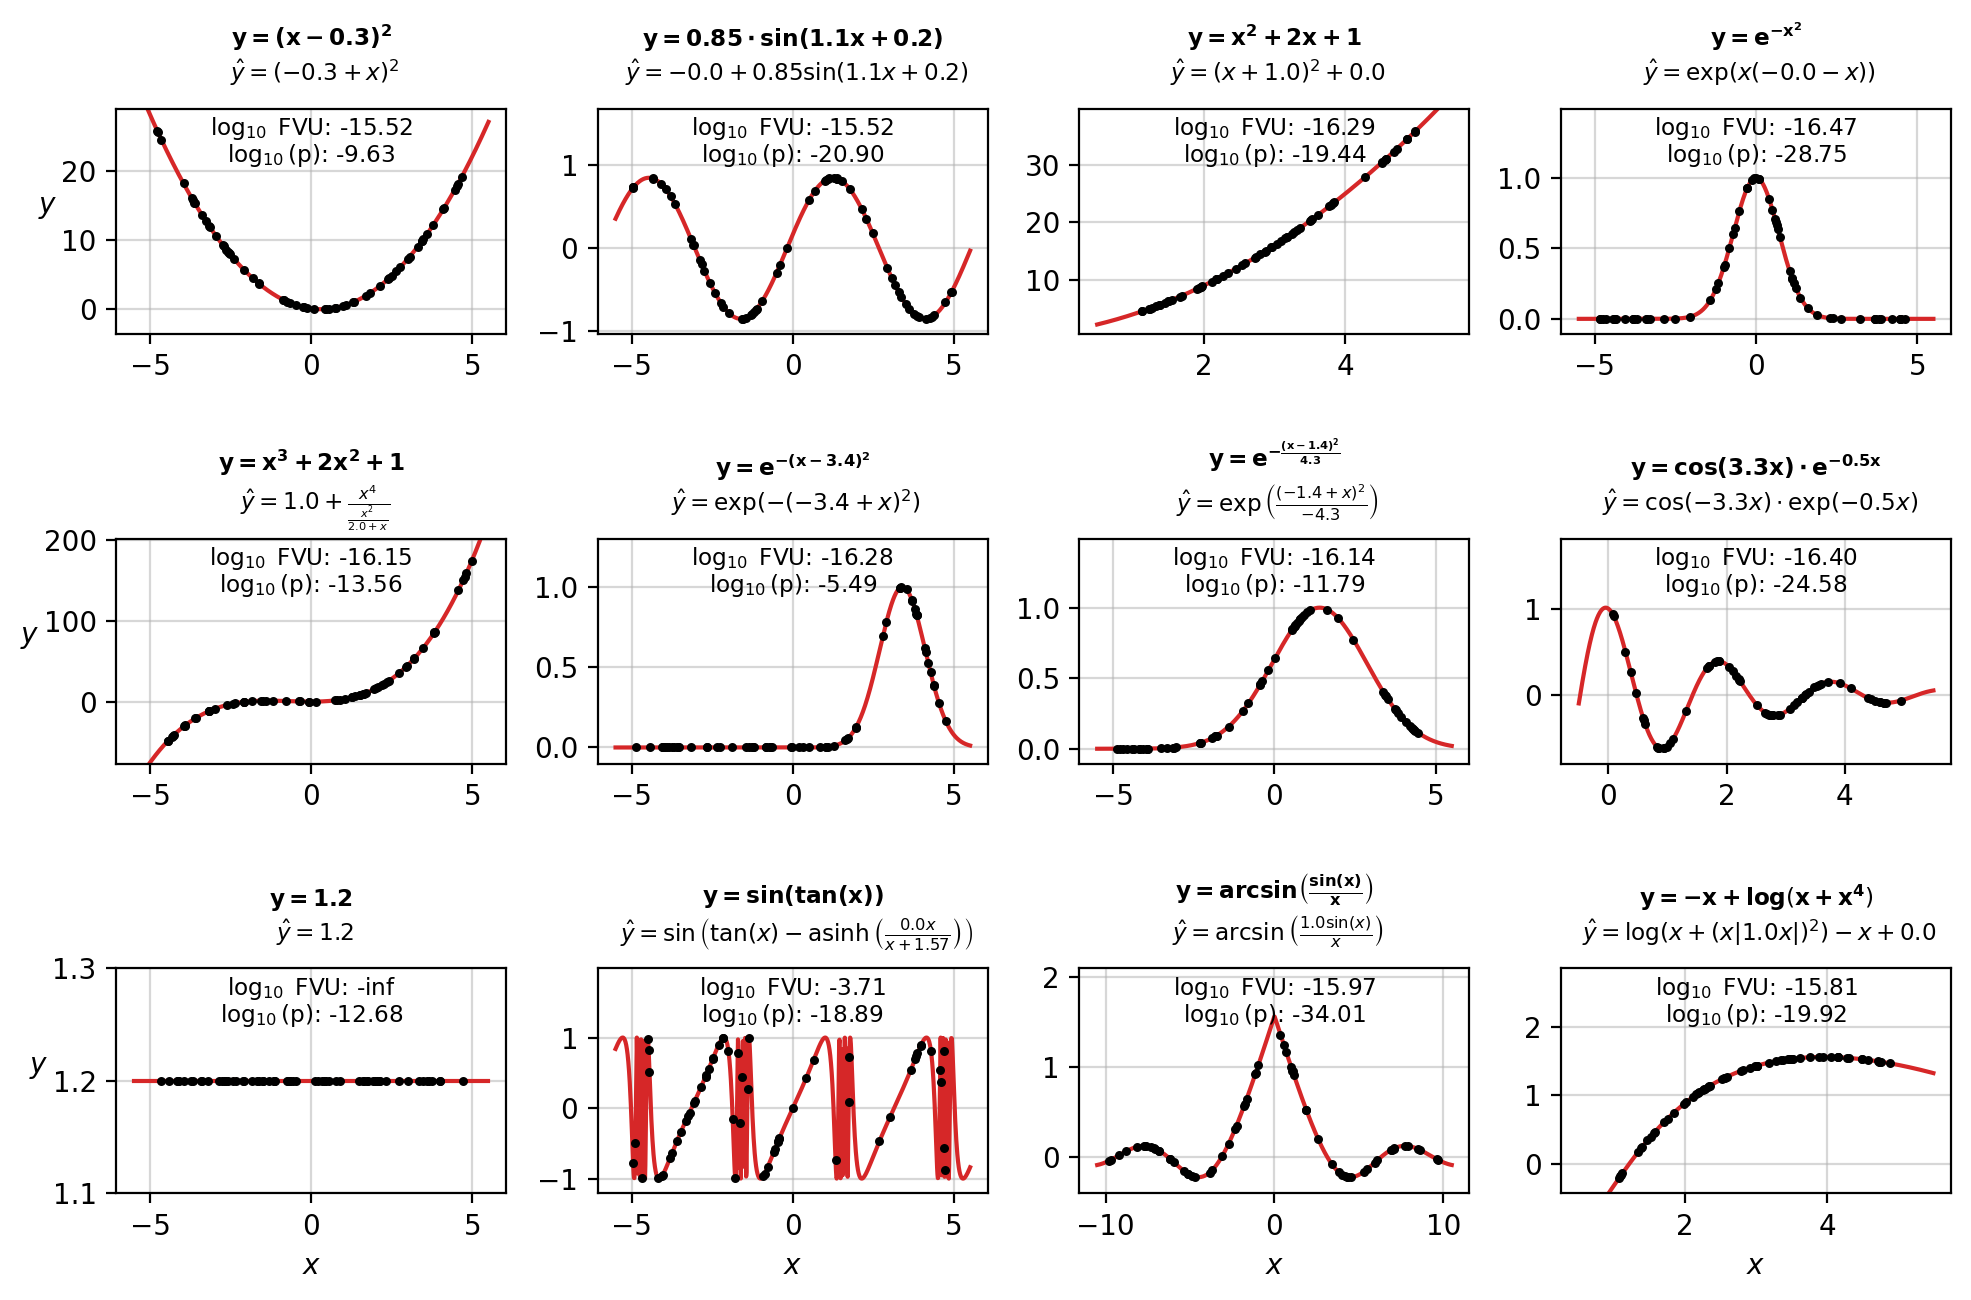

In [18]:
plot_fit = True
results = positive_results
demo_expressions = positive_demo_expressions

COLS = 4
ROWS = np.ceil(len(results) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 2.2), dpi=200)

for i, (ax, result, expression_latex, expression_pred_latex) in enumerate(zip(axes.flat, results, expressions_latex, expressions_pred_latex)):

    if plot_fit:
        ax.plot(result['x_linspace'][:, 0], result['y_linspace_pred'][:, 0], color='tab:red')
    
    if i >= (ROWS - 1) * COLS:
        ax.set_xlabel('$x$')
    if i % COLS == 0:
        ax.set_ylabel('$y$', rotation=0, labelpad=5)

    ax.scatter(result['x'], result['y'], color='k', s=5, zorder=4)
    ax.grid(alpha=0.5)

    ax.set_title(f'$\mathbf{{y = {expression_latex}}}$\n $\\hat{{y}} = {expression_pred_latex}$', fontsize='small', pad=10)

    ylim_span = ax.get_ylim()[1] - ax.get_ylim()[0]
    new_ylim = ax.get_ylim()[0] - ylim_span * 0.05, ax.get_ylim()[1] + ylim_span * 0.4

    if ylim_span < 1e-3:
        new_ylim = ax.get_ylim()[0] - 0.1, ax.get_ylim()[1] + 0.1
    else:
        padding = 0.125 * (max(result['y']) - min(result['y']))
    
        if ax.get_ylim()[0] < min(result['y']) - padding:
            new_ylim = min(result['y']) - padding * 1, new_ylim[1]

        if ax.get_ylim()[1] > max(result['y']) + padding:
            new_ylim = new_ylim[0], max(result['y']) + padding

    ax.set_ylim(new_ylim)

    if i == 5:
        ax.set_ylim(-0.1, 1.3)
    if i == 10:
        ax.set_ylim(-0.4, 2.1)

    # if plot_fit:
    #     ax.legend(loc='upper center', fontsize='small')

    if plot_fit:
        ax.annotate(f'$\\log_{{10}}$ FVU: {np.log10(result["fvu"]):.2f}', xy=(0.5, 0.97), xycoords='axes fraction', ha='center', va='top', fontsize='small')
        ax.annotate(f'$\\log_{{10}}$(p): {result["log_p"]:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', ha='center', va='top', fontsize='small')

for ax in axes.flat[len(results):]:
    ax.axis('off')

fig.tight_layout(h_pad=2, w_pad=1)

plt.savefig(get_path('results', 'examples', create=True, filename='1d_positive_examples.svg'))

# 2D

In [1]:
from flash_ansr import FlashANSR, SoftmaxSamplingConfig, install_model, get_path, ConvergenceError
from flash_ansr.expressions.compilation import codify
from flash_ansr.expressions.token_ops import identify_constants, flatten_nested_list

import torch
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'ansr-models/v23.0-120M'

In [3]:
model = FlashANSR.load(
    directory=get_path('models', MODEL),
    generation_config=SoftmaxSamplingConfig(choices=1024 * 32),
    parsimony=0.05,
).to(device)

In [4]:
RESOLUTION = 256

In [5]:
positive_demo_expressions = [
    ('x1**2 + x2', None, (-5, 5)),
    ('sin(x1 * x2)', None, (-5, 5)),
    ('x1**2 + 2*x1*x2 + x2**2', (2,), (1, 5)),
    ('x1 * exp(- x2**2)', None, (-5, 5)),
    ('x1**3 + 2*x2**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x1 - x2)**2 / 4.3)', (4.3,), (-10, 10)),
    ('exp(- (x1 - 1.4)**2 / (x2 + 1))', (1.4, 1.0), (1, 10)),
    ('cos(3.3 * x1 + x2) * exp(-x1 * 0.5)', (3.3, 0.5,), (0, 5)),
    ('x2 * sin(0.5 * x1**2)', (0.5,), (-5, 5)),
    ('x1 + 3.2 * exp(-1.8 * x1**2) * sin(x2)', (3.2, -1.8,), (-5, 5)),
    ('0.4 * x1**2 + 3.5 * sin(x1 * x2)', (0.4, 3.5), (-5, 5)),
    ('x1 * x2 + exp(-2 * sin(x1))', (-2,), (-5, 5)),
]

# negative_demo_expressions = [
#     ('sin(1.4 * x1) * exp(cos(x2 - 5.4))', (1.4, 5.4), (-10, 10)),
# ]

positive_results = []
# negative_results = []

for results, demo_expressions in zip([positive_results], [positive_demo_expressions]):
    for expression, constants, xlim in tqdm(demo_expressions):
        parsed_expression = model.simplipy_engine.parse(expression, mask_numbers=True)
        executable_prefix_expression = model.simplipy_engine.operators_to_realizations(parsed_expression)
        prefix_expression_with_constants, constants_names = identify_constants(executable_prefix_expression, inplace=True)
        code_string = model.simplipy_engine.prefix_to_infix(prefix_expression_with_constants, realization=True)
        code = codify(code_string, ['x1', 'x2'] + constants_names)

        if constants is None:
            demo_function = lambda x: model.simplipy_engine.code_to_lambda(code)(*x.T)
        else:
            demo_function = lambda x: model.simplipy_engine.code_to_lambda(code)(*x.T, *constants)

        x = np.random.uniform(*xlim, (100, 2)).astype(np.float32)

        y = demo_function(x)

        if isinstance(y, float):
            y = np.full_like(x, y)

        # Mesh
        x1_linspace = np.linspace(xlim[0] - 5, xlim[1] + 5, RESOLUTION)
        x2_linspace = np.linspace(xlim[0] - 5, xlim[1] + 5, RESOLUTION)
        x1_mesh, x2_mesh = np.meshgrid(x1_linspace, x2_linspace)
        x_linspace = np.vstack([x1_mesh.ravel(), x2_mesh.ravel()]).T
        y_linspace = demo_function(x_linspace).reshape(RESOLUTION, RESOLUTION)

        model.fit(x, y, verbose=True)

        results.append({
            'x': x,
            'y': y,
            'y_pred': model.predict(x),
            'x_linspace': x_linspace,
            'y_linspace': y_linspace,
            'y_linspace_pred': model.predict(x_linspace),
            'expression': expression,
            'expression_pred': model.get_expression(),
            'constants': constants,
            'fvu': np.var(y - model.predict(x)) / np.var(y) if np.var(y) > 0 else 0.0,
            'log_p': model.results['log_prob'][0]
        })

 50%|█████     | 6/12 [08:02<07:51, 78.57s/it]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:522: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
Fitting Constants: 100%|██████████| 30326/30326 [00:17<00:00, 1721.89it/s]
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:522: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
100%|██████████| 12/12 [21:36<00:00, 108.05s/it]


In [7]:
# Store the results
import pickle

with open(get_path('results', 'examples', create=True, filename='2d_positive_examples.pkl'), 'wb') as f:
    pickle.dump(positive_results, f)


# # Load the results
# import pickle

# with open(get_path('results', 'examples', create=True, filename='2d_positive_examples.pkl'), 'rb') as f:
#     positive_results = pickle.load(f)

In [8]:
for r in positive_results:
    print(r['expression'])

x1**2 + x2
sin(x1 * x2)
x1**2 + 2*x1*x2 + x2**2
x1 * exp(- x2**2)
x1**3 + 2*x2**2 + 1
exp(- (x1 - x2)**2 / 4.3)
exp(- (x1 - 1.4)**2 / (x2 + 1))
cos(3.3 * x1 + x2) * exp(-x1 * 0.5)
x2 * sin(0.5 * x1**2)
x1 + 3.2 * exp(-1.8 * x1**2) * sin(x2)
0.4 * x1**2 + 3.5 * sin(x1 * x2)
x1 * x2 + exp(-2 * sin(x1))


In [9]:
for r in positive_results:
    print(r['expression_pred'])

(x2 + pow2(x1)) / 1.0
tanh(31.89 + x1) * sin(x1 * x2)
pow2(x1 + 1.0 * x2) - -0.0
x1 * exp(-pow2(x2)) / 1.0
pow3(x1) + mult2(pow2(x2)) - -1.0
exp(pow2(x1 - x2) / -4.3)
exp(pow2(x1 - 1.4) / (-1.0 - x2))
exp(-0.5 * x1) * cos(x2 + 3.3 * x1)
(x2 - 0.0) * sin(0.5 * pow2(x1))
x1 + 3.2 / (exp(pow2(-1.34 * x1)) / sin(x2))
0.4 * pow2(x1) + 3.5 * sin(x1 * x2)
x1 * x2 + exp(-mult2(sin(x1))) - -0.0


In [33]:
# Converted to LaTeX with Gemini
expressions_latex = [
    r"x_1^2 + x_2",
    r"sin(x_1 x_2)",
    r"x_1^2 + 2 x_1 x_2 + x_2^2",
    r"x_1 exp(-x_2^2)",
    r"x_1^3 + 2 x_2^2 + 1",
    r"exp\left(-\frac{(x_1 - x_2)^2}{4.3}\right)",
    r"exp\left(-\frac{(x_1 - 1.4)^2}{x_2 + 1}\right)",
    r"cos(3.3 x_1 + x_2) exp(-0.5 x_1)",
    r"x_2 sin(0.5 x_1^2)",
    r"x_1 + 3.2 exp(-1.8 x_1^2) sin(x_2)",
    r"0.4 x_1^2 + 3.5 sin(x_1 x_2)",
    r"x_1 x_2 + exp(-2 sin(x_1))"
]

expressions_pred_latex = [
    "x_2 + x_1^2",
    "\\tanh(31.89 + x_1) \\sin(x_1 x_2)",
    "(x_1 + x_2)^2",
    "x_1 \\exp(-x_2^2)",
    "x_1^3 + 2 x_2^2 + 1.0",
    "\\exp\\left(\\frac{(x_1 - x_2)^2}{-4.3}\\right)",
    "\\exp\\left(\\frac{(x_1 - 1.4)^2}{-1.0 - x_2}\\right)",
    "\\exp(-0.5 x_1) \\cos(x_2 + 3.3 x_1)",
    "x_2 \\sin(0.5 x_1^2)",
    "x_1 + \\frac{3.2}{\\frac{\\exp((-1.34 x_1)^2)}{\\sin(x_2)}}",
    "0.4 x_1^2 + 3.5 \\sin(x_1 x_2)",
    "x_1 x_2 + \\exp(-2 \\sin(x_1))"
]


/tmp/ipykernel_5636/33842725.py:82: RuntimeWarning: invalid value encountered in subtract
  y_err = (y_pred_mesh - y_mesh) / denom


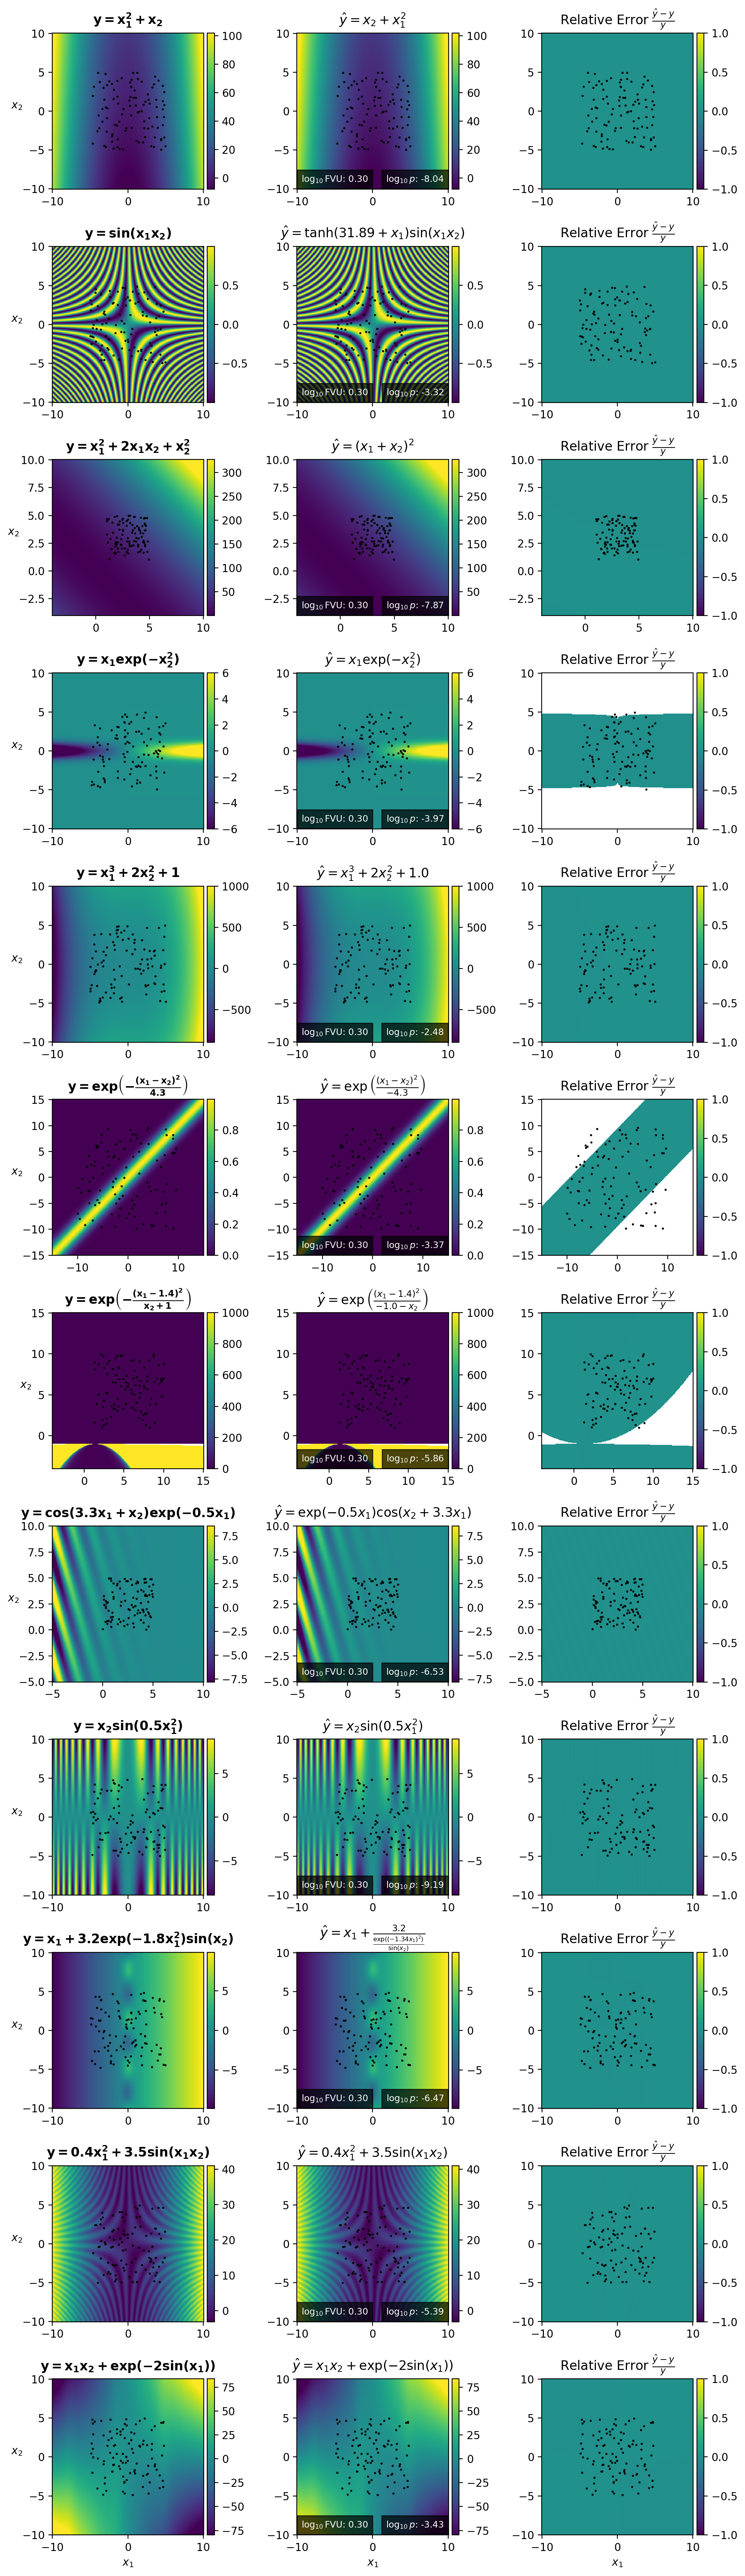

In [36]:
results = positive_results
demo_expressions = positive_demo_expressions
# results = negative_results
# demo_expressions = negative_demo_expressions

COLS = 1
ROWS = int(np.ceil(len(results) / COLS))

s = 1.0

fig, axes = plt.subplots(ROWS, COLS * 3, figsize=(COLS * 3 * 3.1 * s, ROWS * 2.8 * s), dpi=200)
axes = np.atleast_2d(axes)

meshes_gt = []
meshes_pred = []
meshes_err = []

def _reshape_grid(x_linspace, y_values):
    """Reshape flattened grid and values back to mesh form."""
    x_grid = x_linspace.reshape(RESOLUTION, RESOLUTION, 2)
    y_grid = np.asarray(y_values)
    if y_grid.ndim == 3 and y_grid.shape[-1] == 1:
        y_grid = np.squeeze(y_grid, axis=-1)
    if y_grid.size == RESOLUTION * RESOLUTION:
        y_grid = y_grid.reshape(RESOLUTION, RESOLUTION)
    return x_grid, y_grid

for r in range(ROWS):
    for c in range(COLS):
        i = r * COLS + c
        if i >= len(results):
            break
        result = results[i]

        x_grid, y_mesh = _reshape_grid(result['x_linspace'], result['y_linspace'])
        _, y_pred_mesh = _reshape_grid(result['x_linspace'], result['y_linspace_pred'])

        vmin = np.nanpercentile(y_mesh, 1)
        vmax = min(1000, np.nanpercentile(y_mesh, 99))

        # --- Ground Truth ---
        ax_gt = axes[r, 0 + 3 * c]
        mesh_gt = ax_gt.pcolormesh(
            x_grid[:, :, 0],
            x_grid[:, :, 1],
            y_mesh,
            vmin=vmin,
            vmax=vmax,
            # rasterized=True
        )
        meshes_gt.append(mesh_gt)
        ax_gt.set_title(f"$\\mathbf{{y = {expressions_latex[i]}}}$", pad=8)

        # --- Prediction ---
        ax_pred = axes[r, 1 + 3 * c]
        mesh_pred = ax_pred.pcolormesh(
            x_grid[:, :, 0],
            x_grid[:, :, 1],
            y_pred_mesh,
            vmin=vmin,
            vmax=vmax,
            # rasterized=True
        )
        meshes_pred.append(mesh_pred)
        expression_pred = result.get('expression_pred', 'N/A')
        ax_pred.set_title(f"$\hat{{y}} = {expressions_pred_latex[i]}$", pad=8)

        fvu_val = float(result.get('fvu', np.nan))
        log10_fvu = np.log10(fvu_val) if np.isfinite(fvu_val) and fvu_val > 0 else np.nan
        log_p_val = float(result.get('log_p', np.nan))
        log10_p = log_p_val / np.log(10) if np.isfinite(log_p_val) else np.nan

        ax_pred.annotate(f'$\\log_{{10}}\\mathrm{{FVU}}$: {log10_fvu:.2f}', xy=(0.03, 0.03),
                         xycoords='axes fraction', ha='left', va='bottom', fontsize='small',
                         color='w', zorder=5, bbox=dict(facecolor='k', alpha=0.7, edgecolor='black'))
        ax_pred.annotate(f'$\\log_{{10}} p$: {log10_p:.2f}', xy=(0.97, 0.03),
                         xycoords='axes fraction', ha='right', va='bottom', fontsize='small',
                         color='w', zorder=5, bbox=dict(facecolor='k', alpha=0.7, edgecolor='black'))

        # --- Relative Error ---
        denom = np.where(np.abs(y_mesh) > 1e-9, y_mesh, np.nan)
        y_err = (y_pred_mesh - y_mesh) / denom
        ax_err = axes[r, 2 + 3 * c]
        mesh_err = ax_err.pcolormesh(
            x_grid[:, :, 0],
            x_grid[:, :, 1],
            y_err,
            vmin=-1,
            vmax=1,
            # rasterized=True
        )
        meshes_err.append(mesh_err)
        ax_err.set_title("Relative Error $\\frac{{\hat{{y}} - y}}{{y}}$", pad=8)

        # --- Mark data points ---
        for ax in [ax_gt, ax_pred, ax_err]:
            ax.scatter(result['x'][:, 0], result['x'][:, 1], color='k', s=1, zorder=4)

# --- Axis labels ---
for ax in axes[:, 0]:
    ax.set_ylabel('$x_2$', rotation=0, labelpad=5)
for ax in axes[-1, :]:
    ax.set_xlabel('$x_1$')

fig.tight_layout(h_pad=1, w_pad=5)

for r in range(ROWS):
    for c in range(COLS):
        i = r * COLS + c
        if i >= len(results):
            break

        for k, mesh in enumerate([meshes_gt, meshes_pred, meshes_err]):
            ax = axes[r, k + 3 * c]
            pos = ax.get_position()

            cbar_left = pos.x1 + 0.005  # a small offset
            cbar_width = 0.01
            cbar_height = pos.y1 - pos.y0
            cax = fig.add_axes([cbar_left, pos.y0, cbar_width, cbar_height])
            fig.colorbar(mesh[i], cax=cax)


plt.savefig(get_path('results', 'examples', create=True, filename='2d_positive_examples.png'), dpi=200, bbox_inches='tight')